## Analysis of Unrestrained Fully Coupled Trajectory to Generate Parameters for Multiple Distance Restraints

To create the environment required for this notebook, run

```bash
conda create -n biosimspace-dev -c conda-forge -c michellab/label/dev biosimspace
conda activate biosimspace-dev
```

### Get Ligand Heavy Atoms. Find Potential Anchor Points for Each

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.distances import dist
from MDAnalysis.lib.distances import calc_dihedrals
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import nglview as nv

# FIXME: Replace with paths to your own trajectory and topology files
u = mda.Universe("find_restraints_input/SYSTEM.top", "find_restraints_input/traj_poseA.dcd")

lig_heavy = u.select_atoms("resname LIG and not name H*")

# anchors dict of dict. For each ligand heavy atom there is a dictionary of protein heavy atoms,
# for each of which there is a dictionary of average distance and standard deviation

anchors_dict = {}
for lig_atom in lig_heavy:
    for prot_atom in u.select_atoms(f"(protein or resname PRT) and (around 10 index {lig_atom.index}) and (not name H*)"): # protein does not recognise PRT
        anchors_dict[(lig_atom.index,prot_atom.index)]={}
        anchors_dict[(lig_atom.index, prot_atom.index)]["dists"]=[]
    

/home/finlayclark/anaconda3/envs/mamba/envs/biosimspace-dev-test/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


### Compute Average Distance and SD


In [2]:
for frame in u.trajectory:
    for lig_atom_index, prot_atom_index in anchors_dict.keys():
        distance = dist(mda.AtomGroup([u.atoms[lig_atom_index]]), mda.AtomGroup([u.atoms[prot_atom_index]]), box=frame.dimensions)[2][0]
        anchors_dict[(lig_atom_index,prot_atom_index)]["dists"].append(distance)

In [3]:
# change lists to numpy arrays
for pair in anchors_dict.keys():
    anchors_dict[pair]["dists"] = np.array(anchors_dict[pair]["dists"])

In [4]:
# calculate average and SD
for pair in anchors_dict.keys():
    anchors_dict[pair]["avg_dist"] = anchors_dict[pair]["dists"].mean()
    anchors_dict[pair]["sd_dist"] = anchors_dict[pair]["dists"].std()

In [5]:
# get n pairs with lowest SD
pairs_ordered_sd=[]
for item in sorted(anchors_dict.items(), key=lambda item: item[1]["sd_dist"]):
    pairs_ordered_sd.append(item[0])
    print(f'Pair: {item[0]}, av distance: {item[1]["avg_dist"]:.2f}, SD: {item[1]["sd_dist"]:.2f}')

Pair: (21, 4950), av distance: 2.72, SD: 0.12
Pair: (21, 4946), av distance: 4.85, SD: 0.15
Pair: (11, 4950), av distance: 3.64, SD: 0.15
Pair: (21, 4949), av distance: 3.37, SD: 0.15
Pair: (11, 4946), av distance: 5.92, SD: 0.15
Pair: (11, 4949), av distance: 4.51, SD: 0.16
Pair: (3, 4909), av distance: 3.63, SD: 0.18
Pair: (5, 4946), av distance: 8.27, SD: 0.18
Pair: (5, 4949), av distance: 6.87, SD: 0.18
Pair: (11, 4955), av distance: 8.79, SD: 0.18
Pair: (11, 4954), av distance: 7.96, SD: 0.18
Pair: (3, 4949), av distance: 5.67, SD: 0.18
Pair: (21, 4955), av distance: 7.74, SD: 0.18
Pair: (5, 4950), av distance: 6.01, SD: 0.18
Pair: (3, 4919), av distance: 3.67, SD: 0.18
Pair: (14, 4949), av distance: 7.10, SD: 0.19
Pair: (3, 4946), av distance: 7.12, SD: 0.19
Pair: (14, 4946), av distance: 8.40, SD: 0.19
Pair: (3, 4950), av distance: 4.91, SD: 0.19
Pair: (21, 4954), av distance: 7.02, SD: 0.19
Pair: (11, 65), av distance: 5.77, SD: 0.19
Pair: (11, 68), av distance: 8.15, SD: 0.19


In [6]:
# Print out pairs with lowest SD
print("The ligand-protein atom pairs with the lowest SD in distance are:")
for i in range(5):
    print(f"{u.atoms[pairs_ordered_sd[i][0]]} and {u.atoms[pairs_ordered_sd[i][1]]}")


The ligand-protein atom pairs with the lowest SD in distance are:
<Atom 22: OAA of type oh of resname LIG, resid 1 and segid SYSTEM> and <Atom 4951: OD1 of type O of resname ASN, resid 326 and segid SYSTEM>
<Atom 22: OAA of type oh of resname LIG, resid 1 and segid SYSTEM> and <Atom 4947: CB of type 2C of resname ASN, resid 326 and segid SYSTEM>
<Atom 12: CAP of type ca of resname LIG, resid 1 and segid SYSTEM> and <Atom 4951: OD1 of type O of resname ASN, resid 326 and segid SYSTEM>
<Atom 22: OAA of type oh of resname LIG, resid 1 and segid SYSTEM> and <Atom 4950: CG of type C of resname ASN, resid 326 and segid SYSTEM>
<Atom 12: CAP of type ca of resname LIG, resid 1 and segid SYSTEM> and <Atom 4947: CB of type 2C of resname ASN, resid 326 and segid SYSTEM>


In [7]:
# print out indices of top 20 ligand atoms
lig_anchors = []

for i in range(20):
    print(pairs_ordered_sd[i][0], end=' ')
    lig_anchors.append(pairs_ordered_sd[i][0])
    
print(f"\n\nThe number of unique ligand anchors is: {len(set(lig_anchors))}")

21 21 11 21 11 11 3 5 5 11 11 3 21 5 3 14 3 14 3 21 

The number of unique ligand anchors is: 5


### Ensure no Duplicated Atoms in Restraints

In [8]:
unique_pairs_ordered_sd = []
lig_ats = []
recept_ats = []

for pair in pairs_ordered_sd:
    if pair[0] not in lig_ats:
        if pair[1] not in recept_ats:
            unique_pairs_ordered_sd.append(pair)
            lig_ats.append(pair[0])
            recept_ats.append(pair[1])
            if len(unique_pairs_ordered_sd) == 22:
                break

In [9]:
# print out indices of anchor atoms in top 20 pairs

for i in range(22):
    print(unique_pairs_ordered_sd[i][0], unique_pairs_ordered_sd[i][1], end=' ')
    #print(anchors_dict[unique_pairs_ordered_sd[i]]["sd_dist"])

21 4950 11 4946 3 4909 5 4949 4 971 2 1613 14 963 20 959 10 950 12 51 18 4951 13 47 19 49 6 53 17 34 16 45 9 548 15 48 7 584 8 1633 0 1737 1 4914 

### Plot

In [10]:
def get_distance(idx1, idx2, u):
    """ Distance in Angstrom"""
    distance = dist(mda.AtomGroup([u.atoms[idx1]]), mda.AtomGroup([u.atoms[idx2]]), box=u.dimensions)[2][0]
    return distance

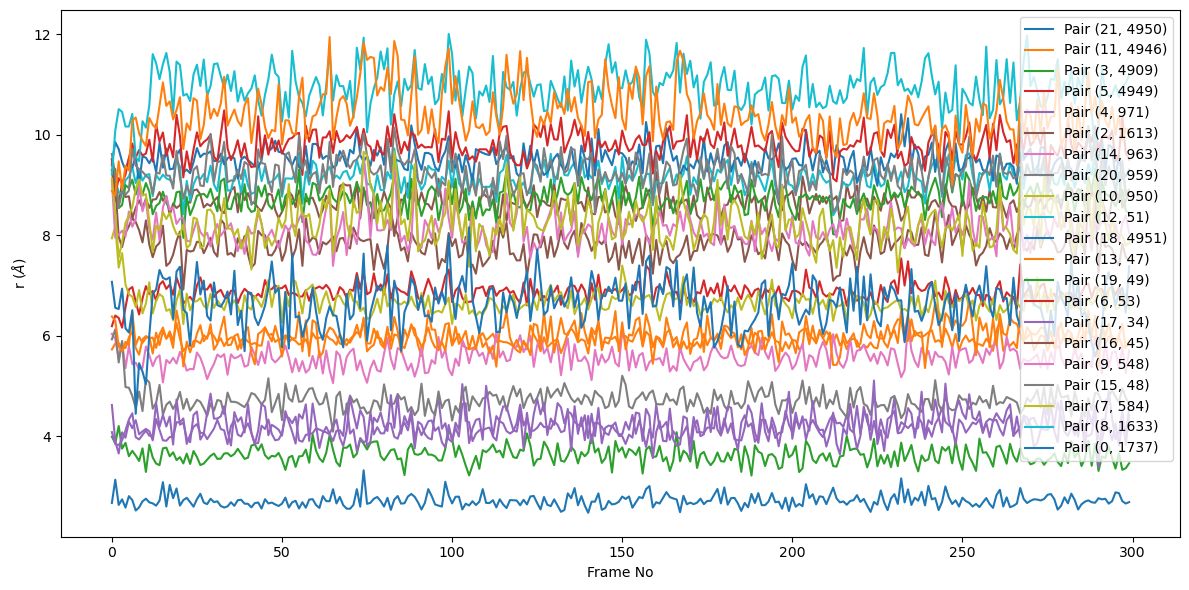

In [11]:
num_pairs = 22

fig, ax = plt.subplots(1,1, figsize=(12,6))
for i, pair in enumerate(unique_pairs_ordered_sd):
    if i > -1:
        ax.plot([x for x in range(300)], anchors_dict[pair]["dists"],label=f"Pair {pair}")
        ax.set_ylabel("r ($\AA$)")
        if i == num_pairs-1:
            break
    ax.set_xlabel("Frame No")
    ax.legend()
fig.tight_layout()



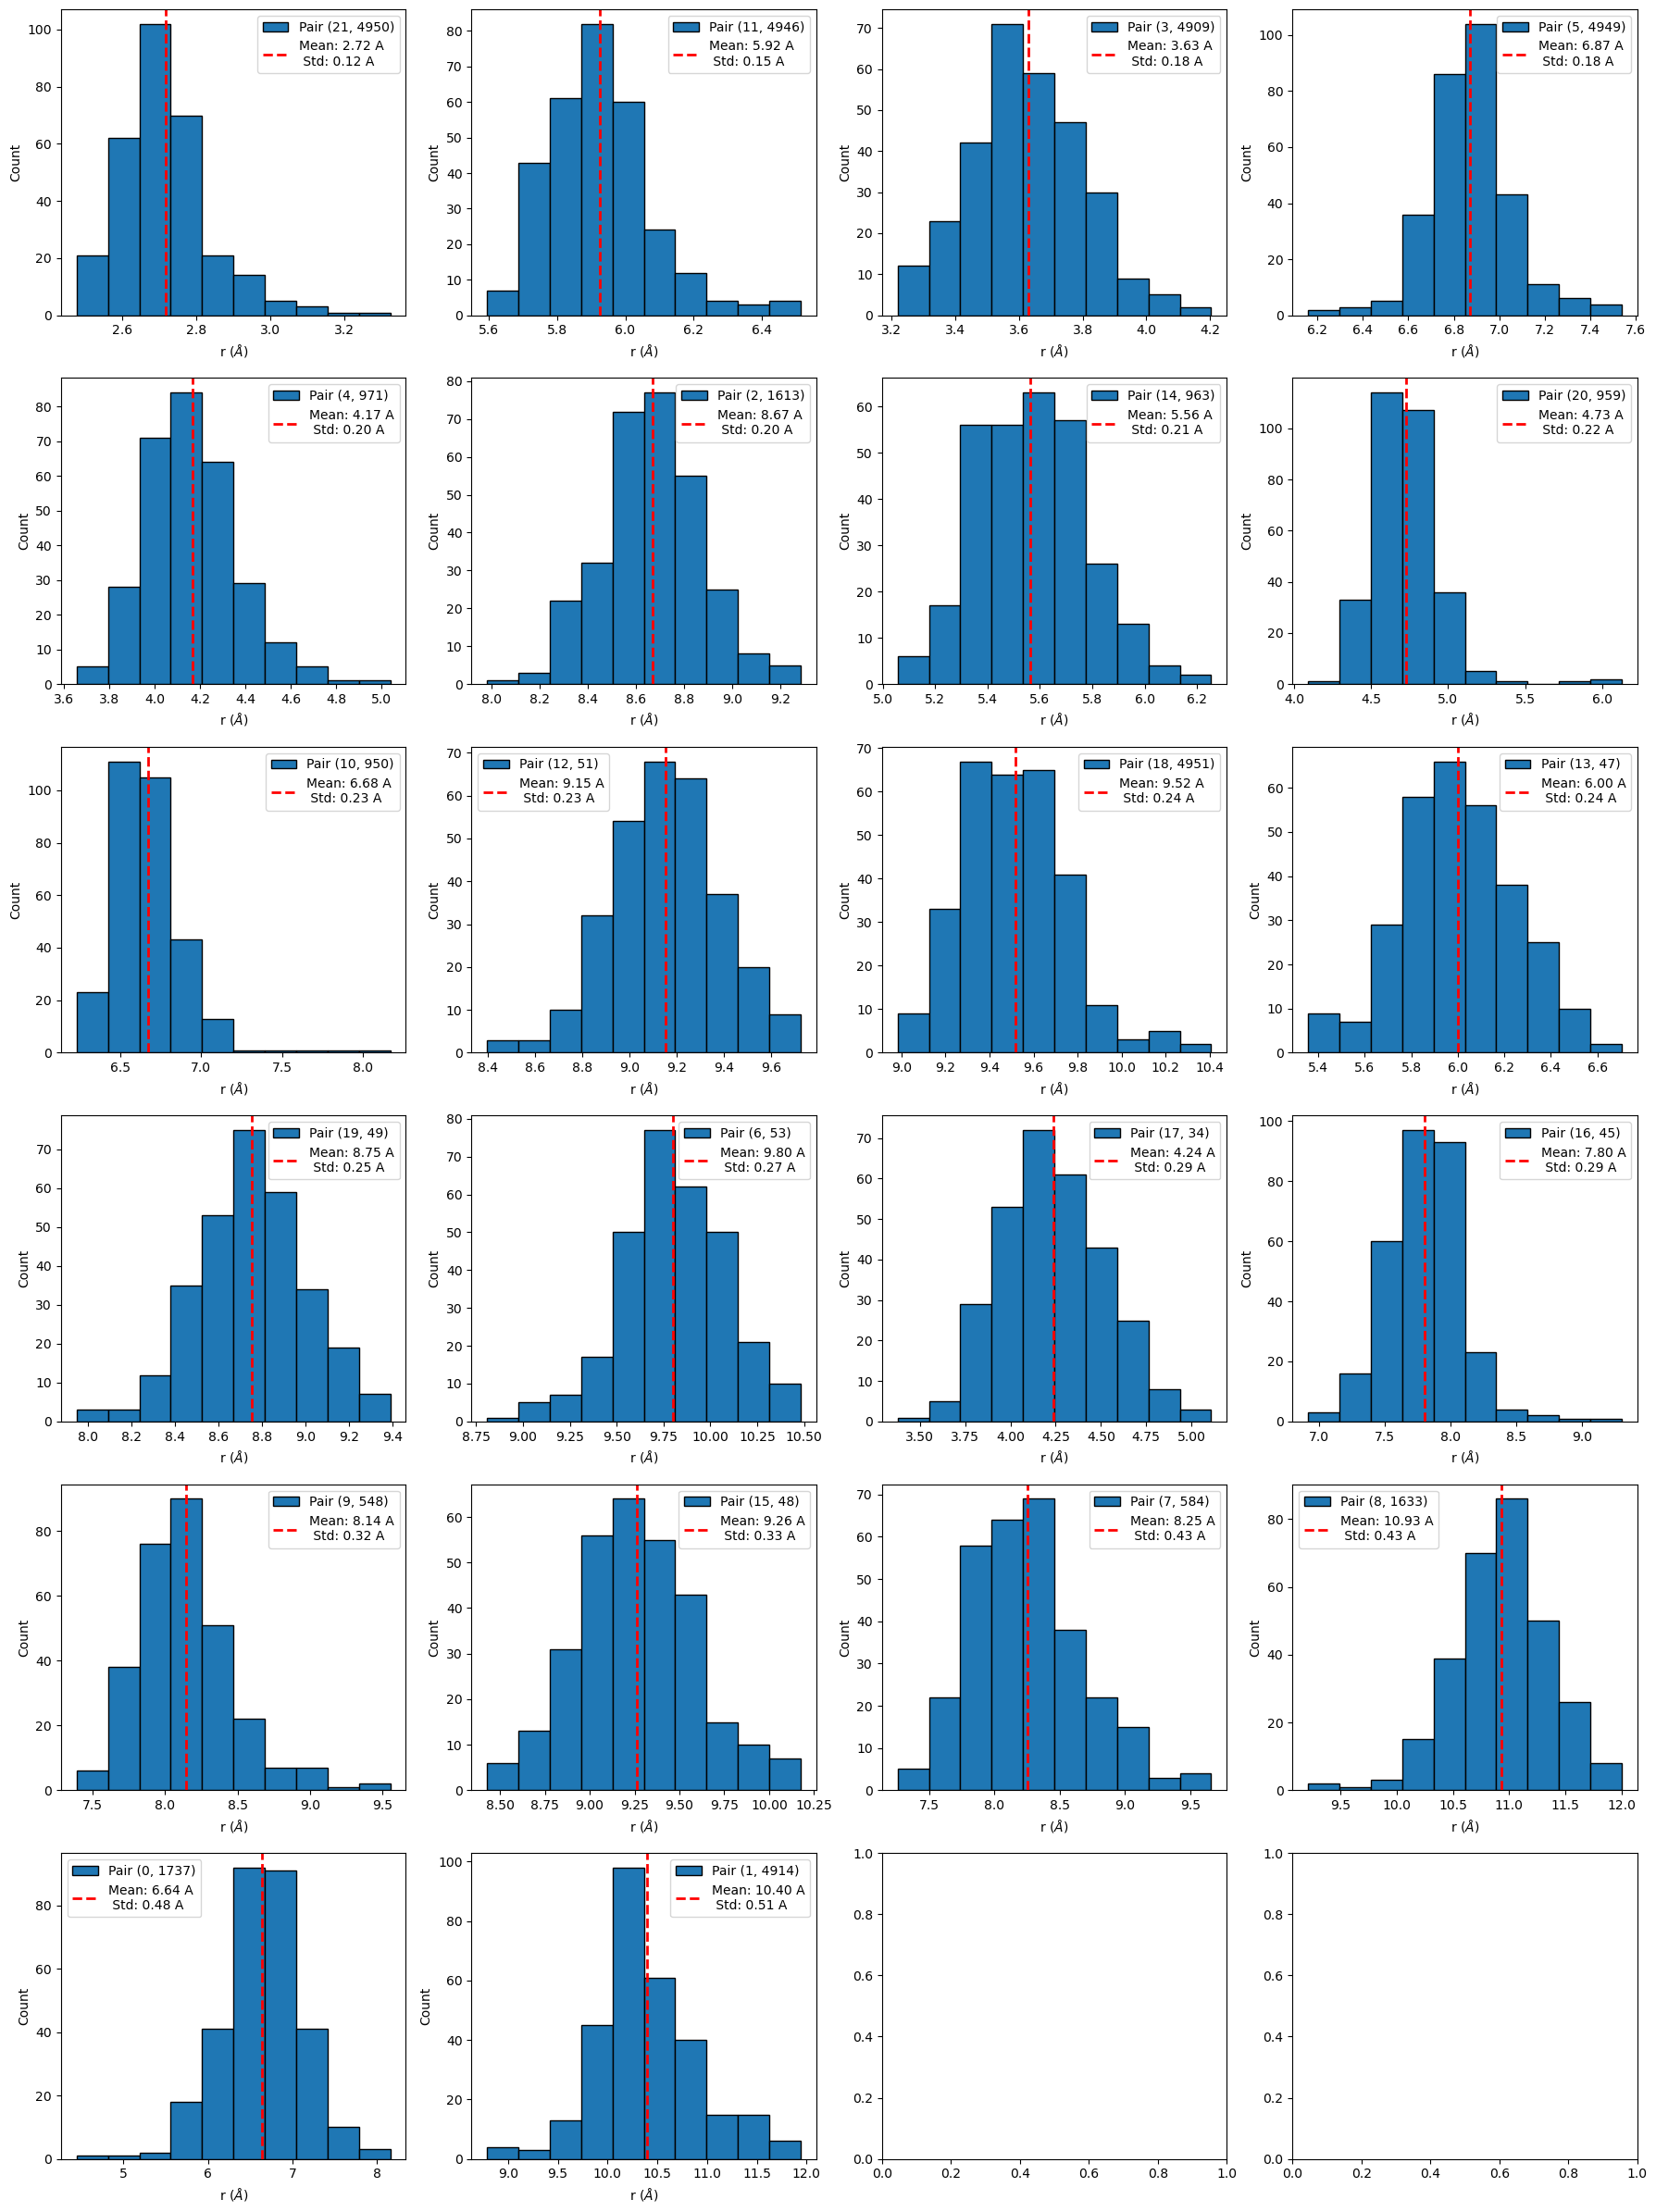

In [12]:
# Plot histograms

fig, axs = plt.subplots(6, len(unique_pairs_ordered_sd)%6, figsize=(18,6*(len(unique_pairs_ordered_sd)%6)))
axs = axs.flatten()
for i, pair in enumerate(unique_pairs_ordered_sd):
    axs[i].hist(anchors_dict[pair]["dists"],label=f"Pair {pair}", edgecolor='k')
    axs[i].axvline(anchors_dict[pair]["avg_dist"], color='r', linestyle = "dashed", linewidth=2, label=f'Mean: {anchors_dict[pair]["avg_dist"]:.2f} A\n Std: {anchors_dict[pair]["sd_dist"]:.2f} A')
    axs[i].set_xlabel("r ($\AA$)")
    axs[i].set_ylabel("Count")
    axs[i].legend()
fig.tight_layout()


### Generate Restraints by Assuming Gaussian Distributions

In [13]:
# Select flat-bottomed region to contain 95 % of the probability density from test simulation, then set high force constants
# for the half-harmonic potentials
# Form of restraints: restraints = { (i0, i1): (r01, kl, Dl), (i0,i2): (r02, kl, Dl) }

restraints = {}

for pair in unique_pairs_ordered_sd:
    r0 = round(anchors_dict[pair]["avg_dist"],2) # A
    kl = 0.593/(anchors_dict[pair]["sd_dist"]**2) # RT at 289 K is 0.593 kcal mol-1
    kl /= 2 # Correct for definition of force constant in SOMD
    kl = round(kl, 2)
    dl = 0
    restraints[pair] = (r0, kl, dl)

In [14]:
print(restraints)

{(21, 4950): (2.72, 19.55, 0), (11, 4946): (5.92, 12.75, 0), (3, 4909): (3.63, 9.64, 0), (5, 4949): (6.87, 9.28, 0), (4, 971): (4.17, 7.42, 0), (2, 1613): (8.67, 7.07, 0), (14, 963): (5.56, 6.81, 0), (20, 959): (4.73, 6.07, 0), (10, 950): (6.68, 5.77, 0), (12, 51): (9.15, 5.64, 0), (18, 4951): (9.52, 5.31, 0), (13, 47): (6.0, 5.02, 0), (19, 49): (8.75, 4.94, 0), (6, 53): (9.8, 3.92, 0), (17, 34): (4.24, 3.64, 0), (16, 45): (7.8, 3.59, 0), (9, 548): (8.14, 2.81, 0), (15, 48): (9.26, 2.74, 0), (7, 584): (8.25, 1.63, 0), (8, 1633): (10.93, 1.6, 0), (0, 1737): (6.64, 1.28, 0), (1, 4914): (10.4, 1.13, 0)}
